<a href="https://colab.research.google.com/github/ktanguy/Summative/blob/main/Summative_Intro_to_ml_Tanguy_Kwizera_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [27]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import joblib

In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [5]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)
!rm -rf /content/rice-plant-diseases*
!rm -f rice-plant-diseases-dataset.zip

# Download the dataset (same format as PlantVillage download)
!kaggle datasets download -d jay7080dev/rice-plant-diseases-dataset --force

# Unzip with correct directory structure (like PlantVillage)
!unzip -q rice-plant-diseases-dataset.zip -d /content/rice-plant-diseases

# Verify the structure matches PlantVillage's
!ls /content/rice-plant-diseases

Dataset URL: https://www.kaggle.com/datasets/jay7080dev/rice-plant-diseases-dataset
License(s): apache-2.0
 64% 113M/176M [00:00<00:00, 1.17GB/s]
100% 176M/176M [00:00<00:00, 918MB/s] 
'rice leaf diseases dataset'


In [29]:
##  Load & Preprocess Dataset
data_dir = '/content/rice-plant-diseases/rice leaf diseases dataset'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Detected Classes:", train_ds.class_indices)

Found 3748 images belonging to 3 classes.
Found 936 images belonging to 3 classes.
Detected Classes: {'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
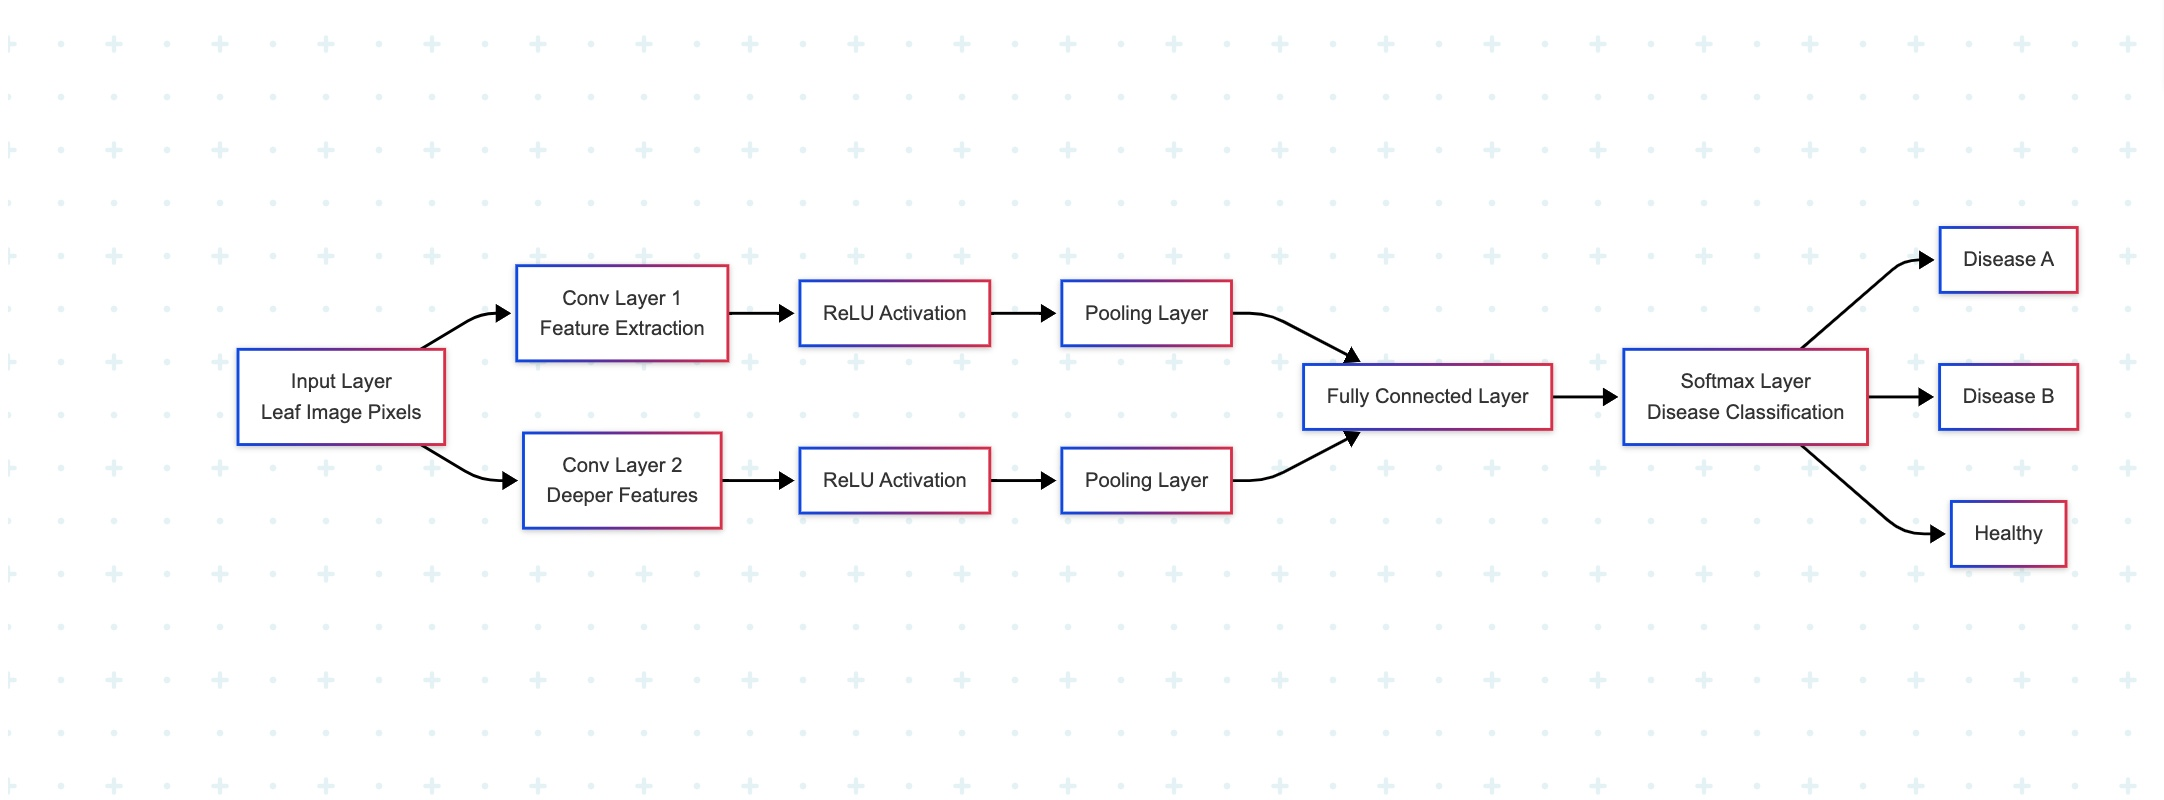



#Task: Define a function that creates models without and With specified Optimization techniques


In [30]:
## Define Modular Model Function
def define_model(optimizer_name='adam', regularization_type=None, early_stopping=False,
                 dropout=0.0, learning_rate=0.001, layers=3, train_data=None, val_data=None, epochs=10):

    model = Sequential()
    reg = None
    if regularization_type == 'l1':
        reg = l1(0.001)
    elif regularization_type == 'l2':
        reg = l2(0.001)
    elif regularization_type == 'l1_l2':
        reg = l1_l2(0.001)

    model.add(Input(shape=(224, 224, 3)))
    for _ in range(layers - 1):
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=reg))
        model.add(MaxPooling2D((2, 2)))
        if dropout > 0:
            model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
    model.add(Dense(train_data.num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate) if optimizer_name.lower() == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)] if early_stopping else []

    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks)
    return model, history

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [31]:
import matplotlib.pyplot as plt

def loss_curve_plot(history):
    # Extract loss and val_loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Print final accuracy
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title('Training and Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [10]:
## Model 1 – Default (No Optimization)
model_1, history_1 = define_model(
    optimizer_name='adam',
    regularization_type=None,
    early_stopping=False,
    dropout=0.0,
    learning_rate=0.001,
    layers=3,
    train_data=train_ds,
    val_data=val_ds,
    epochs=10
)
import os

# Make sure the directory exists
os.makedirs("saved_models", exist_ok=True)

# Now save the model
model_1.save("saved_models/model_1_default.keras")


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.6398 - loss: 1.1650 - val_accuracy: 0.8301 - val_loss: 0.4745
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8575 - loss: 0.3551 - val_accuracy: 0.9306 - val_loss: 0.2287
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9195 - loss: 0.2206 - val_accuracy: 0.9605 - val_loss: 0.1052
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9734 - loss: 0.0739 - val_accuracy: 0.9861 - val_loss: 0.0479
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9959 - loss: 0.0233 - val_accuracy: 0.9882 - val_loss: 0.0485
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9930 - loss: 0.0345 - val_accuracy: 0.9893 - val_loss: 0.0333
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9968 - val_loss: 0.0139
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 1.0000 - loss: 0.0016 - val_accu

In [11]:
##Model 2 – Adam + L2 + EarlyStopping
model_2, history_2 = define_model(
    optimizer_name='adam',
    regularization_type='l2',
    early_stopping=True,
    dropout=0.3,
    learning_rate=0.0005,
    layers=3,
    train_data=train_ds,
    val_data=val_ds,
    epochs=15
)
model_2.save("saved_models/model_2_adam_l2.keras")

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.4497 - loss: 1.8837 - val_accuracy: 0.6848 - val_loss: 0.9864
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7479 - loss: 0.7377 - val_accuracy: 0.7286 - val_loss: 0.8526
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8057 - loss: 0.6212 - val_accuracy: 0.7767 - val_loss: 0.7386
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8543 - loss: 0.5215 - val_accuracy: 0.8429 - val_loss: 0.5950
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8933 - loss: 0.4353 - val_accuracy: 0.8900 - val_loss: 0.4708
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9118 - loss: 0.3800 - val_accuracy: 0.8878 - val_loss: 0.4363
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.9469 - loss: 0.2987 - val_accuracy: 0.9316 - val_loss: 0.3662
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9497 - loss: 0.2970 - val_accu

In [12]:
##Model 3 – RMSprop (No Reg, No EarlyStopping)
model_3, history_3 = define_model(
    optimizer_name='rmsprop',
    regularization_type=None,
    early_stopping=False,
    dropout=0.2,
    learning_rate=0.001,
    layers=3,
    train_data=train_ds,
    val_data=val_ds,
    epochs=5
)
model_3.save("saved_models/model_3_rmsprop.keras")

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.4863 - loss: 3.6142 - val_accuracy: 0.6934 - val_loss: 0.8253
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7339 - loss: 0.6740 - val_accuracy: 0.7286 - val_loss: 0.6985
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8329 - loss: 0.4631 - val_accuracy: 0.8814 - val_loss: 0.3487
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9032 - loss: 0.2601 - val_accuracy: 0.9444 - val_loss: 0.1894
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9494 - loss: 0.1514 - val_accuracy: 0.9541 - val_loss: 0.1329


In [13]:
## Model 4 – Adam + L1+L2 + EarlyStopping
model_4, history_4 = define_model(
    optimizer_name='adam',
    regularization_type='l1_l2',
    early_stopping=True,
    dropout=0.4,
    learning_rate=0.0003,
    layers=4,
    train_data=train_ds,
    val_data=val_ds,
    epochs=5
)
model_4.save("saved_models/model_4_best.keras")

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.4727 - loss: 9.0340 - val_accuracy: 0.6709 - val_loss: 2.7537
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.7082 - loss: 2.3099 - val_accuracy: 0.7564 - val_loss: 1.9576
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.7320 - loss: 1.7545 - val_accuracy: 0.7746 - val_loss: 1.6809
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7653 - loss: 1.5534 - val_accuracy: 0.7863 - val_loss: 1.5328
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7714 - loss: 1.3931 - val_accuracy: 0.7831 - val_loss: 1.3878


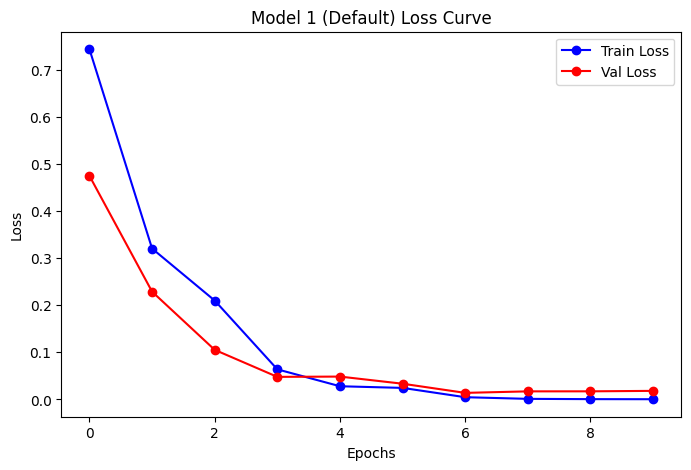

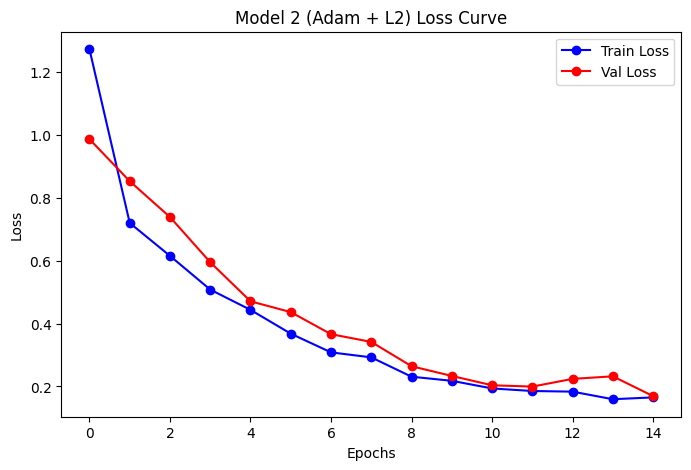

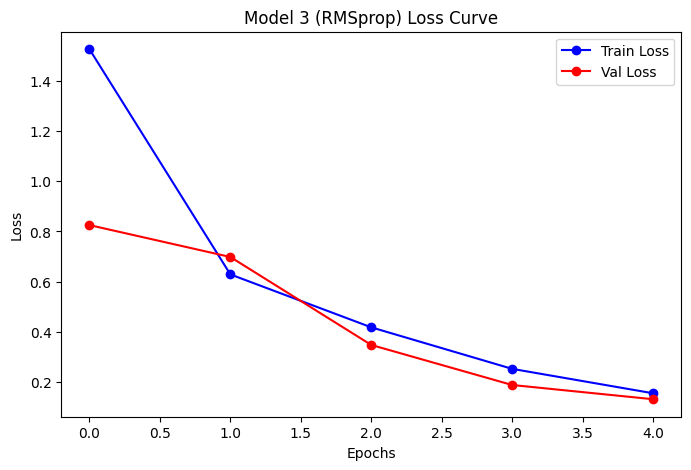

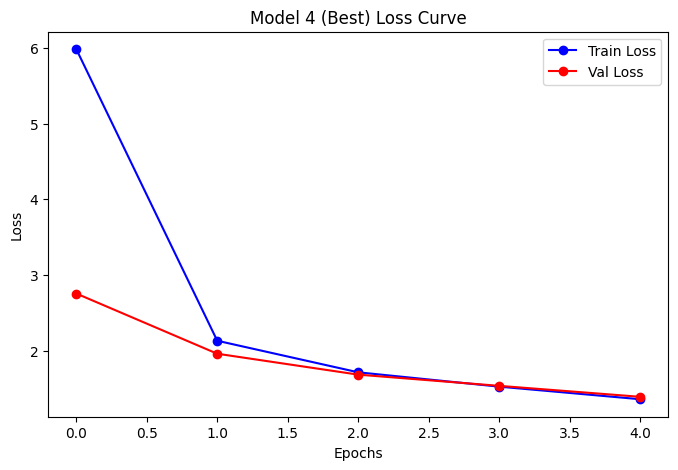

In [14]:
## Plot Loss Curve Function
def loss_curve_plot(history, title="Loss Curve"):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], 'bo-', label='Train Loss')
    plt.plot(history.history['val_loss'], 'ro-', label='Val Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

loss_curve_plot(history_1, "Model 1 (Default) Loss Curve")
loss_curve_plot(history_2, "Model 2 (Adam + L2) Loss Curve")
loss_curve_plot(history_3, "Model 3 (RMSprop) Loss Curve")
loss_curve_plot(history_4, "Model 4 (Best) Loss Curve")

In [15]:
## Classical ML Model – Logistic Regression
X_train, y_train = next(train_ds)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_labels = y_train.argmax(axis=1)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_flat, y_train_labels)
joblib.dump(clf, "saved_models/model_classical_lr.pkl")

['saved_models/model_classical_lr.pkl']

30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step
📋 Model 1 (Default) Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.36      0.36      0.36       320
      Brownspot       0.36      0.36      0.36       324
       Leafsmut       0.34      0.34      0.34       292

       accuracy                           0.35       936
      macro avg       0.35      0.35      0.35       936
   weighted avg       0.35      0.35      0.35       936



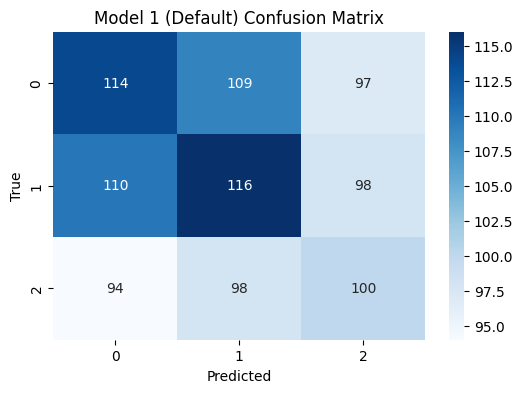

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 532ms/step
📋 Model 2 (Adam + L2) Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.36      0.35      0.35       320
      Brownspot       0.34      0.35      0.34       324
       Leafsmut       0.31      0.31      0.31       292

       accuracy                           0.34       936
      macro avg       0.34      0.34      0.34       936
   weighted avg       0.34      0.34      0.34       936



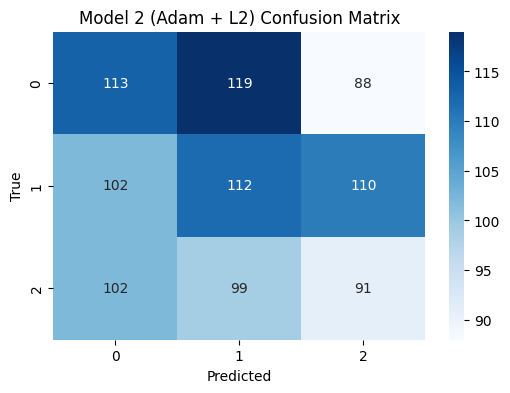

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 537ms/step
📋 Model 3 (RMSprop) Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.41      0.42      0.42       320
      Brownspot       0.31      0.30      0.31       324
       Leafsmut       0.30      0.30      0.30       292

       accuracy                           0.34       936
      macro avg       0.34      0.34      0.34       936
   weighted avg       0.34      0.34      0.34       936



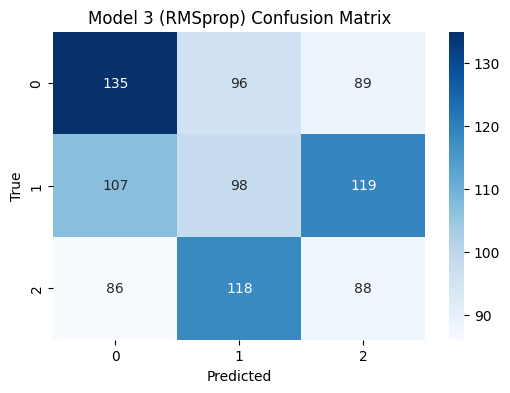

30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 596ms/step
📋 Model 4 (Best) Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.37      0.35      0.36       320
      Brownspot       0.37      0.43      0.40       324
       Leafsmut       0.33      0.28      0.30       292

       accuracy                           0.36       936
      macro avg       0.36      0.36      0.36       936
   weighted avg       0.36      0.36      0.36       936



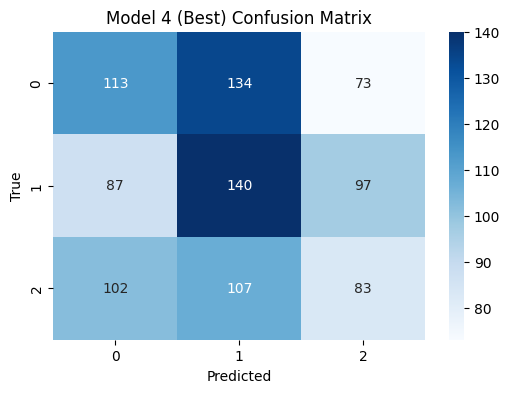

In [16]:
## 10. 📈 Evaluation Function
def evaluate_model(model, val_data, title="Model"):
    val_data.reset()
    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes

    print(f"📋 {title} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model_1, val_ds, "Model 1 (Default)")
evaluate_model(model_2, val_ds, "Model 2 (Adam + L2)")
evaluate_model(model_3, val_ds, "Model 3 (RMSprop)")
evaluate_model(model_4, val_ds, "Model 4 (Best)")

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [17]:
from tensorflow.keras.models import load_model
import numpy as np

def make_predictions(model_path, data_generator):
    # Load the trained model
    model = load_model(model_path)

    # Predict probabilities
    preds = model.predict(data_generator)

    # Convert probabilities to class indices
    predicted_classes = np.argmax(preds, axis=1)

    return predicted_classes


30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 598ms/step


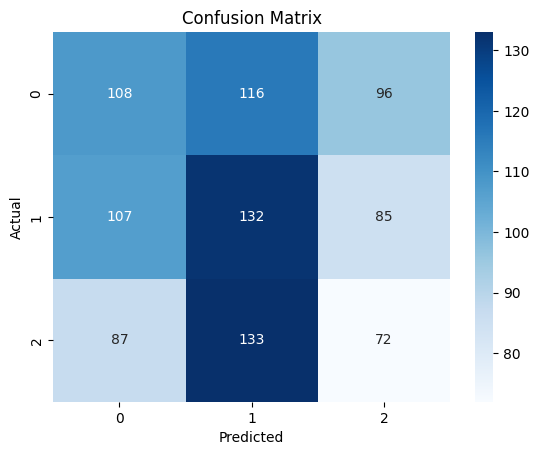


Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.36      0.34      0.35       320
      Brownspot       0.35      0.41      0.37       324
       Leafsmut       0.28      0.25      0.26       292

       accuracy                           0.33       936
      macro avg       0.33      0.33      0.33       936
   weighted avg       0.33      0.33      0.33       936



In [22]:
# Get true labels from val_data
true_labels = val_ds.classes

# Predict using best model
y_pred = make_predictions('saved_models/model_4_best.keras', val_ds)

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, y_pred, target_names=val_ds.class_indices.keys()))


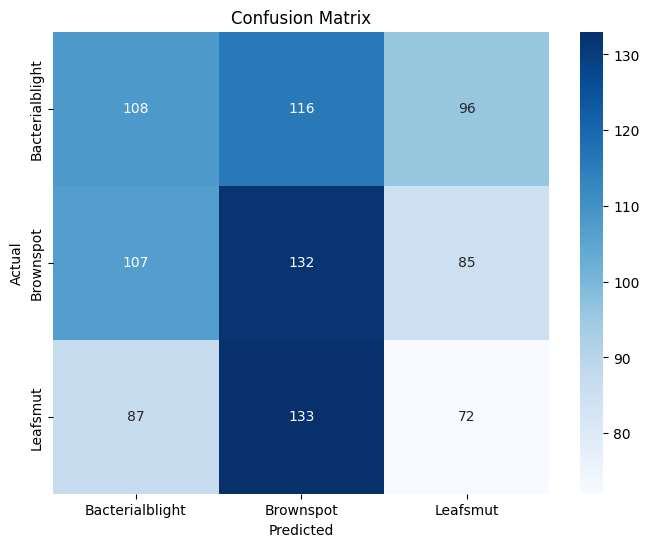


Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.36      0.34      0.35       320
      Brownspot       0.35      0.41      0.37       324
       Leafsmut       0.28      0.25      0.26       292

       accuracy                           0.33       936
      macro avg       0.33      0.33      0.33       936
   weighted avg       0.33      0.33      0.33       936



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get actual labels
true_labels = val_ds.classes
class_names = list(val_ds.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, y_pred, target_names=class_names))


In [34]:
model_path = "saved_models/model_4_best.keras"
predicted_labels = make_predictions(model_path, val_ds)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step


Congratulations!!
